In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [9]:
stock = 'GOOG'
start = '2012-01-01'
end = '2025-04-05'
data = yf.download(stock, start=start, end=end)
data.dropna(inplace=True)
data.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [10]:
pd.set_option('display.max_columns', None)
display(data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].head())

Price,Date,Open,High,Low,Close,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG
0,2012-01-03,16.185880,16.562924,16.171749,16.495001,147611217
1,2012-01-04,16.485582,16.614982,16.376262,16.566147,114989399
2,2012-01-05,16.413692,16.459304,16.267435,16.336349,131808205
3,2012-01-06,16.339819,16.360891,16.107792,16.113495,108119746
4,2012-01-09,16.026237,16.038633,15.399813,15.430305,233776981


In [11]:
print(f"Start Date: {data['Date'].iloc[0]}, End Date: {data['Date'].iloc[-1]}")

Start Date: 2012-01-03 00:00:00, End Date: 2025-04-04 00:00:00


In [12]:
data['50_MA'] = data['Close'].rolling(50).mean()
data['100_MA'] = data['Close'].rolling(100).mean()
data['200_MA'] = data['Close'].rolling(200).mean()

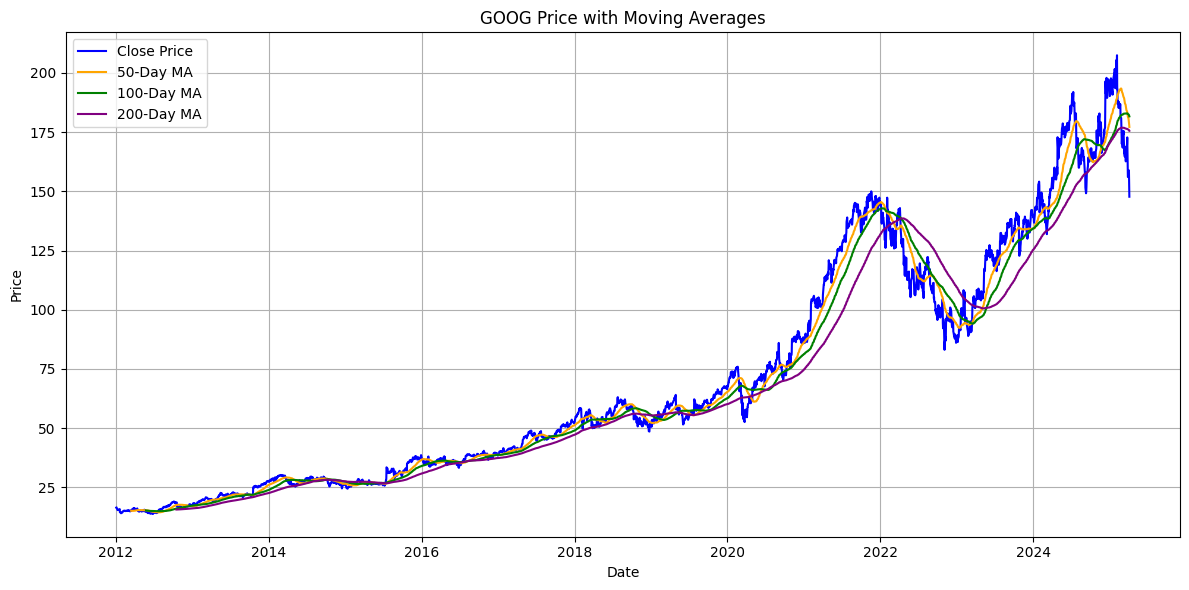

In [13]:
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
plt.plot(data['Date'], data['50_MA'], label='50-Day MA', color='orange')
plt.plot(data['Date'], data['100_MA'], label='100-Day MA', color='green')
plt.plot(data['Date'], data['200_MA'], label='200-Day MA', color='purple')
plt.title(f"{stock} Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

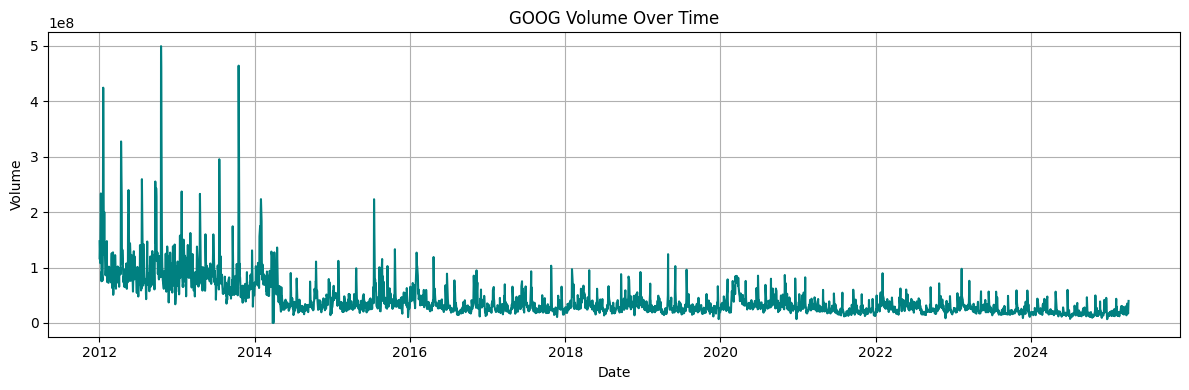

In [14]:
plt.figure(figsize=(12,4))
plt.plot(data['Date'], data['Volume'], color='teal')
plt.title(f"{stock} Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
close_data = data[['Date', 'Close']]
train_size = int(len(close_data) * 0.6)
data_train = close_data[:train_size].copy()
data_test = close_data[train_size:].copy()

In [16]:
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train[['Close']])

In [17]:
x_train, y_train = [], []
for i in range(100, len(data_train_scaled)):
    x_train.append(data_train_scaled[i-100:i])
    y_train.append(data_train_scaled[i])
x_train, y_train = np.array(x_train), np.array(y_train)

In [18]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.0431
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0029
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 0.0024
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 0.0020
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - loss: 0.0016
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.0016
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.0014
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - loss: 0.0015
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - loss: 0.0014
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: 0.0014
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 0.0014
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0012
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - loss: 0.0013
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - loss: 0.0013
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - lo

In [20]:
past_100 = data_train.tail(100)
final_test_data = pd.concat([past_100, data_test], ignore_index=True)
final_test_scaled = scaler.transform(final_test_data[['Close']])

In [22]:
x_test, y_test = [], []
for i in range(100, len(final_test_scaled)):
    x_test.append(final_test_scaled[i-100:i])
    y_test.append(final_test_scaled[i])
x_test, y_test = np.array(x_test), np.array(y_test)

In [23]:
y_predicted = model.predict(x_test)
scale_factor = 1 / scaler.scale_[0]
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


In [24]:
mse = mean_squared_error(y_test, y_predicted)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predicted)
mape = mean_absolute_percentage_error(y_test, y_predicted) * 100
accuracy = 100 - mape

In [25]:
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%, Accuracy: {accuracy:.2f}%")

MSE: 223.35, RMSE: 14.94, R²: 0.8178, MAPE: 8.01%, Accuracy: 91.99%


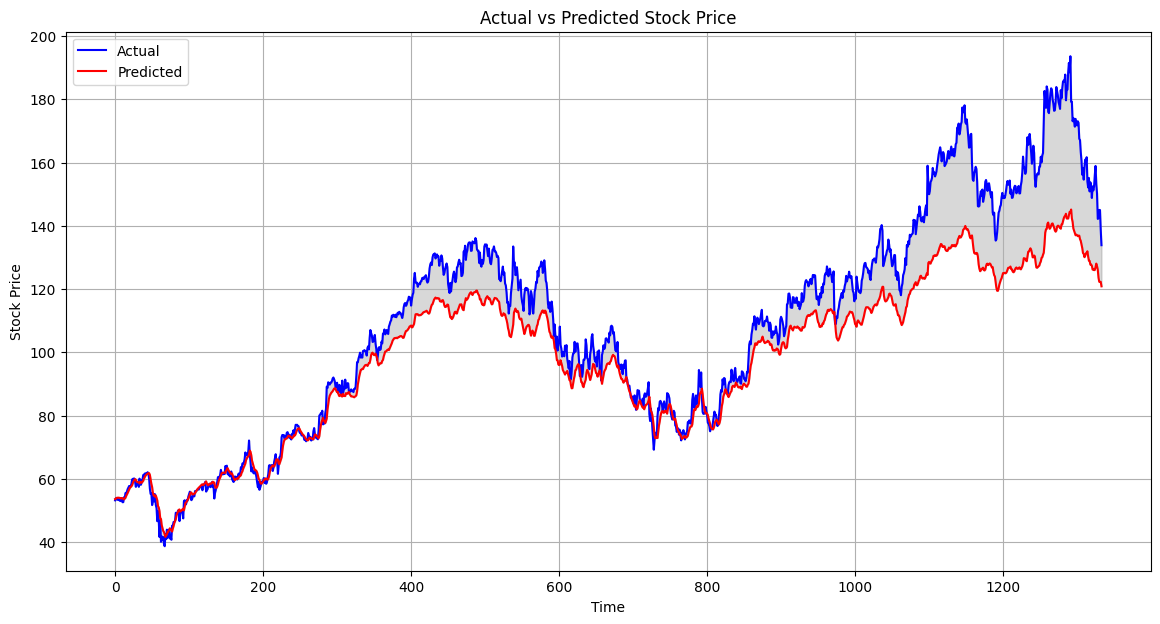

In [26]:
plt.figure(figsize=(14,7))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_predicted, label='Predicted', color='red')
plt.fill_between(range(len(y_test)), y_test.ravel(), y_predicted.ravel(), color='gray', alpha=0.3)
plt.title("Actual vs Predicted Stock Price")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
min_len = min(len(data_test['Date'].iloc[100:]), len(y_test), len(y_predicted))

results_df = pd.DataFrame({
    'Date': data_test['Date'].iloc[100:100+min_len].values,
    'Actual Price': y_test.ravel()[:min_len],
    'Predicted Price': y_predicted.ravel()[:min_len]
})

In [33]:
model.save('Stock_Predictions_Model.keras')